# Project 使用FAST算法提取图片特征点
# 01: CV & Python
> 该项目改编自AMD AECG的[FAST](https://github.com/Maxwellhyh/AMD_AECG_Summer_School_Projects/tree/main/fast)，使用Xilinx Vitis HLS生成的FAST Algo IP来进行图片特征点提取操作

## 检查输入图片（按行展开为128*128一维数组）

`src.txt`是一个文本文件，包含128*128图片每个像素的灰度信息


In [1]:
rows = 128
cols = 128
threshold = 20

# Tips: 图片转码
将图片`in.jpg`转换为128x128的灰阶图片，按行展开转化为大小为128x128的一维数组（uint8）并存入in.txt文件

In [2]:
import numpy as np
from PIL import Image

# Load the image
img = Image.open('in.jpg')

# Convert to grayscale
img_gray = img.convert('L')

# Resize to 128x128
img_resized = img_gray.resize((rows, cols))

# Convert to numpy array and flatten
image_flattened = np.array(img_resized).flatten()
image_flattened_qual = image_flattened.astype(np.uint8)

# Save to txt
np.savetxt('in.txt', image_flattened_qual, fmt='%i')


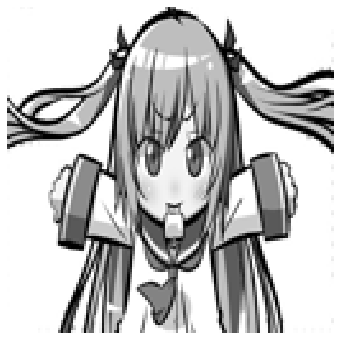

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Read the file
with open('in.txt', 'r') as f:
    data = f.read().splitlines()

# Convert to numpy array and reshape
image = np.array([np.uint8(x) for x in data]).reshape(rows, cols)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

### 加载Overlay

Overlay模块封装了ARM CPU与FPGA的PL部分进行交互的接口。

- 我们可以通过简单的`Overlay()`方法将刚才生成的硬件设计加载到PL上
- 通过`overlay.fast_accel_0`语句，我们可以通过访问的Python对象的形式来与IP交互

In [4]:
from pynq import Overlay
overlay = Overlay("./fast.bit")
fast = overlay.fast_accel_0
overlay.ip_dict

{'fast_accel_0/s_axi_control': {'fullpath': 'fast_accel_0/s_axi_control',
  'type': 'xilinx.com:hls:fast_accel:1.0',
  'bdtype': None,
  'state': None,
  'addr_range': 65536,
  'phys_addr': 1073741824,
  'mem_id': 's_axi_control',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_CTRL_ADDR_WIDTH': '6',
   'C_S_AXI_CTRL_DATA_WIDTH': '32',
   'C_S_AXI_CONTROL_ADDR_WIDTH': '6',
   'C_S_AXI_CONTROL_DATA_WIDTH': '32',
   'C_M_AXI_GMEM_ID_WIDTH': '1',
   'C_M_AXI_GMEM_ADDR_WIDTH': '64',
   'C_M_AXI_GMEM_DATA_WIDTH': '32',
   'C_M_AXI_GMEM_AWUSER_WIDTH': '1',
   'C_M_AXI_GMEM_ARUSER_WIDTH': '1',
   'C_M_AXI_GMEM_WUSER_WIDTH': '1',
   'C_M_AXI_GMEM_RUSER_WIDTH': '1',
   'C_M_AXI_GMEM_BUSER_WIDTH': '1',
   'C_M_AXI_GMEM_USER_VALUE': '0x00000000',
   'C_M_AXI_GMEM_PROT_VALUE': '"000"',
   'C_M_AXI_GMEM_CACHE_VALUE': '"0011"',
   'C_M_AXI_GMEM_ENABLE_ID_PORTS': 'true',
   'C_M_AXI_GMEM_ENABLE_USER_PORTS': 'false',
   'Component_Name': 'design_1_fast_accel_0_0',


### 分配内存供IP使用
`pynq.allocate`函数用于为PL中的IP分配可以使用的内存空间。
- 在PL中的IP访问DRAM之前，必须为其保留一些内存供IP使用，分配大小与地址
- 我们分别为输入、输出和权重三个部分分配内存，数据类型为int32
- `pynq.allocate`会分配物理上的连续内存，并返回一个`pynq.Buffer`表示已经分配缓冲区的对象

In [5]:
from pynq import allocate
img_in = allocate(shape=(rows*cols,), dtype=np.uint8)
img_out = allocate(shape=(rows*cols,), dtype=np.uint8)

将python的本地内存中的音频数据和系数数据，复制到我们刚分配的内存中。

In [6]:
np.copyto(img_in, image.flatten())

In [7]:
img_in.physical_address

377798656

### 配置IP

我们可以直接使用IP的`write`方法，将刚分配的内存空间的地址写入到IP对应位置上

对于数据长度，我们可以直接在对应寄存器写入值。

In [8]:
fast.s_axi_control.write(0x10,img_in.physical_address)
fast.s_axi_control.write(0x1c,img_out.physical_address)
fast.s_axi_CTRL.write(0x10, threshold)
fast.s_axi_CTRL.write(0x18, rows)
fast.s_axi_CTRL.write(0x20, cols)

### 启动IP

控制信号位于0x00地址，我们可以对其进行写入与读取来控制IP启动、监听是否完成。

In [9]:
import time

fast.s_axi_CTRL.write(0x00, 0x01)
start_time = time.time()
while True:
    reg = fast.s_axi_CTRL.read(0x00)
    if reg != 1:
        break
end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.022472858428955078s


结果已经被写入到了`img_out`中，我们可以进行查看

In [10]:
img_out[10000:10009]

PynqBuffer([255,   0,   0,   0, 255,   0,   0,   0, 255], dtype=uint8)

### 可视化结果

仍然使用上述绘图组件，我们对硬件函数的结果进行可视化

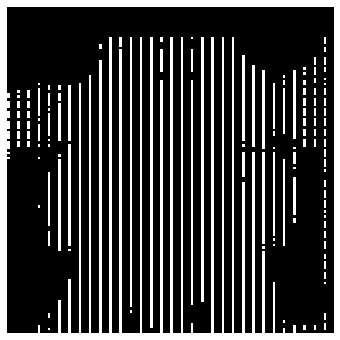

In [11]:
# Convert to numpy array and reshape
image = np.array([np.uint8(x) for x in img_out]).reshape(rows, cols)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()